In [20]:
import hoomd
import hoomd.md
import gsd.hoomd
import numpy as np
import math
import os
import random
import freud
import matplotlib.pyplot as plt

In [21]:
# initialize HOOMD
device = hoomd.device.CPU()  # auto-select CPU
simulation = hoomd.Simulation(device=device, seed = 0)

In [22]:
# parameters
N = 64  # number of particles
fraction_si = 0.7
n_si = int(N * fraction_si)
n_li = N - n_si
box_length = 25 
kT = 1.5  
mass_li = 6.941  
mass_si = 28.0855
mass = (mass_li + mass_si) / 2

In [23]:
# initialize particles in a random cubic lattice
snapshot = hoomd.Snapshot()
snapshot.particles.N = N
snapshot.particles.types = ['Li', 'Si']

typeids = [0] * n_si + [1] * n_li  # 0 for Si, 1 for Li
np.random.shuffle(typeids)  # shuffle typeids

particles_per_dim = int(round(N ** (1 / 3)))
assert particles_per_dim ** 3 == N, "N must be a perfect cube for a simple cubic lattice."

# generate a simple cubic lattice
positions = []
for x in range(particles_per_dim):
    for y in range(particles_per_dim):
        for z in range(particles_per_dim):
            # Calculate the position in the box
            positions.append([
                -box_length / 2 + (x + 0.5) * box_length / particles_per_dim,
                -box_length / 2 + (y + 0.5) * box_length / particles_per_dim,
                -box_length / 2 + (z + 0.5) * box_length / particles_per_dim,
            ])

# assign shuffled typeids and lattice positions to the snapshot
snapshot.particles.typeid[:] = typeids
snapshot.particles.position[:] = positions
snapshot.configuration.box = [box_length, box_length, box_length, 0, 0, 0]

simulation.create_state_from_snapshot(snapshot)

In [24]:
# save our lattice as a gsd
try:
    os.remove("lattice.gsd")
except OSError:
    pass
hoomd.write.GSD.write(state=simulation.state, mode="xb", filename="lattice.gsd")

In [25]:
# run HPMC simulation to quickly randomize the system
mc = hoomd.hpmc.integrate.Sphere()
mc.shape["Li"] = dict(diameter = 1)
mc.shape["Si"] = dict(diameter = 2)
simulation.operations.integrator = mc

simulation.run(1e4)

In [26]:
# save our initial randomized state as a gsd
try:
    os.remove("random.gsd")
except OSError:
    pass
hoomd.write.GSD.write(state=simulation.state, mode="xb", filename="random.gsd")

In [27]:
# LJ-NPT alloying simulation code
# get initial velocities based on temperature
snapshot = simulation.state.get_snapshot()
if device.communicator.rank == 0:
    np.random.seed(42)  # Seed for reproducibility
    velocities = np.random.normal(0, np.sqrt(kT / mass), size=(snapshot.particles.N, 3))
    snapshot.particles.velocity[:] = velocities
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
simulation.state.set_snapshot(snapshot)

# LJ params from https://openkim.org/files/MO_959249795837_003/LennardJones612_UniversalShifted.params
eps_AA = 1.0496900
eps_BB = 3.1743100
sig_AA = 2.2807000
sig_BB = 1.9778000
r_cut_AA = 3 #9.1228000 # had to reduce r_cut to prevent simulation box shrinkage from causing crashes
r_cut_BB = 3 #7.9111800

# calculate A-B interactions via Lorentz-Berthelot combining rules
# see https://en.wikipedia.org/wiki/Combining_rules
eps_AB = math.sqrt(eps_AA * eps_BB)
sig_AB = (sig_AA + sig_BB) / 2
r_cut_AB = (r_cut_AA + r_cut_BB) / 2

cell = hoomd.md.nlist.Cell(buffer=0.4)  # neighbor list
lj = hoomd.md.pair.LJ(nlist = cell) # use LJ pair potential

# define LJ potentials
lj.params[('Li', 'Li')] = dict(epsilon=eps_AA, sigma=sig_AA)
lj.params[('Si', 'Si')] = dict(epsilon=eps_BB, sigma=sig_BB)
lj.params[('Si', 'Li')] = dict(epsilon=eps_AB, sigma=sig_AB)

lj.r_cut[('Li', 'Li')] = r_cut_AA
lj.r_cut[('Si', 'Si')] = r_cut_BB
lj.r_cut[('Si', 'Li')] = r_cut_AB

# create integrator and thermostat
integrator = hoomd.md.Integrator(dt=0.0001)
berendsen = hoomd.md.methods.thermostats.Berendsen(kT=kT, tau=1)
berendsen.kT = hoomd.variant.Ramp(A=kT,
                                  B=0.2,
                                  t_start=0,
                                  t_ramp=1000000) # T decreases from kT down to 0.2 over 1000000 steps

### CHOICE NPT ENSEMBLE ###
npt = hoomd.md.methods.ConstantPressure(
    S = 2, tauS = 1, couple = "xyz", filter=hoomd.filter.All(), thermostat = berendsen
)
integrator.methods.append(npt)

### CHOICE NVT ENSEMBLE ###
# nvt = hoomd.md.methods.ConstantVolume(
#     filter=hoomd.filter.All(),
#     thermostat=berendsen
# )
# integrator.methods.append(nvt)

### OPTIONAL ADD FIELD ###
# periodic = hoomd.md.external.field.Periodic()
# periodic.params['Li'] = dict(A=100.0, i=0, w=0.02, p=3)
# periodic.params['Si'] = dict(A=-100.0, i=0, w=0.02, p=3)
# integrator.forces.append(periodic)

integrator.forces.append(lj)
simulation.operations.integrator = integrator

# properties logging
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
simulation.operations.computes.append(thermo_props)

logger = hoomd.logging.Logger()
logger.add(thermo_props, quantities=['kinetic_temperature', 'potential_energy', 'pressure', 'kinetic_energy'])

# reset our gsd file
try:
    os.remove("test000.gsd")
except OSError:
    pass
    
# GSD writer
gsd_writer = hoomd.write.GSD(
    filename="test000.gsd",
    trigger=hoomd.trigger.Periodic(1000),
    mode='wb'
)
simulation.operations.writers.append(gsd_writer)

# run the simulation
simulation.run(1e6)
gsd_writer.flush()

In [28]:
# analyze our trajectory using solid-liquid order parameters
# adapted from https://hoomd-blue.readthedocs.io/en/latest/tutorial/00-Introducing-HOOMD-blue/07-Analyzing-Trajectories.html
traj = gsd.hoomd.open('test000.gsd', 'r')
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

/tmp/ipykernel_427/3675271325.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


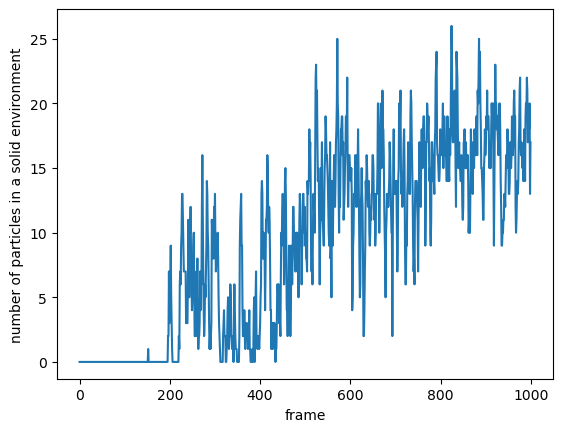

In [29]:
# plot solidity as a function of frame
# adapted from https://hoomd-blue.readthedocs.io/en/latest/tutorial/00-Introducing-HOOMD-blue/07-Analyzing-Trajectories.html
fig, ax = plt.subplots()
num_solid = np.array([np.sum(a) for a in is_solid])
ax.plot(num_solid[:1000])
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig.show()